In [1]:
import pandas as pd
import numpy as np
import random
import os, glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
players = pd.read_csv('players.csv')
games = pd.read_csv('games.csv')
plays = pd.read_csv('plays.csv')

path = r'C:\Users\ajaworsk\Desktop\NFL-Data\weeks'
all_weeks = glob.glob(os.path.join(path, "*.csv"))

season = pd.concat((pd.read_csv(file) for file in all_weeks))
alldf = games.merge(season, on='gameId').merge(plays, on=['gameId', 'playId'])
alldf = alldf[alldf.playType != 'play_type_unknown'] # Remove 'no-play' data

In [3]:
def create_field(gameId, playId):
    
    # Create dataframe of play
    play = alldf.loc[(alldf['gameId'] == gameId) & (alldf['playId'] == playId)] 
    
    ymin = max(round(min(play['x']) - 5, -1), 0)
    ymax = min(round(max(play['x']) + 5, -1), 120)
    
    fig, ax = plt.subplots()
    # Field dimensions (yds)
    fieldX = 53.3
    fieldY = 120
    # Figure limits
    ax.set_xlim(0,fieldX)
    ax.set_ylim(ymin,ymax)
    # Hash coordinates
    hashesWidth = 18.5 / 3
    midX = fieldX / 2
    leftHash = (midX - (hashesWidth / 2)) - 1 # x-coord for left hash marks, subtract 1 to account for line length
    rightHash = midX + (hashesWidth / 2)      # x-coord for right hash marks
    for i in range(0, 120):
        if (i > 10) and (i < 110):
            if i % 10 == 0:
                if i < 61:
                    num = i - 10
                    ax.text(10, i, num, rotation=270, ha='center', va='center', fontsize=12)
                    ax.text(43.33333, i, num, rotation=90, ha='center', va='center', fontsize=12)
                else:
                    num = 110 - i
                    ax.text(10, i, num, rotation=270, ha='center', va='center', fontsize=12)
                    ax.text(43.33333, i, num, rotation=90, ha='center', va='center', fontsize=12)
            if i % 5 == 0:
                ax.hlines(i, 0, fieldX)            
            else:
                leftLength = leftHash + 1
                rightLength = rightHash + 1
                ax.hlines(i, leftHash, leftLength)
                ax.hlines(i, rightHash, rightLength)
        # Fill endzones
        if i == 0 or i == 110:
            ax.fill_between([0, fieldX], [i, i], [i + 10, i + 10], color='forestgreen', alpha=0.6)
    
    # Figure size
    figWidth = 6
    figHeight = figWidth * ((ymax - ymin) / fieldX)
    fig.set_size_inches(figWidth, figHeight)
    
    los = play['x'].loc[play['displayName'] == 'Football'].iloc[0]
    ytg = play['yardsToGo'].iloc[0]   
    fd =  los + ytg   
    
    if play['playDirection'].iloc[0] == 'left':
        fd = los - ytg
        ax.invert_xaxis()
        ax.invert_yaxis()
    
    # Plot line of scrimmage and first down line
    plt.hlines(fd, 0, 53.3, color='yellow')
    plt.hlines(los, 0, 53.3, color='blue')
    
    # Plot teams, score, quarter, and description
    visitor = play['visitorTeamAbbr'].iloc[0]
    home = play['homeTeamAbbr'].iloc[0]
    vScore = str(int(play['preSnapVisitorScore'].iloc[0]))
    hScore = str(int(play['preSnapHomeScore'].iloc[0]))
    quarter = 'Q' + str(play['quarter'].iloc[0])
    description = play['playDescription'].iloc[0]
    
    # Title and subtitles
    plt.title(visitor + '\n' + vScore, loc='left', x=0.33)
    plt.title(home + '\n' + hScore, loc='right', x=0.67)
    plt.title(quarter, loc='center')
    plt.xlabel(description, labelpad=15, wrap=True)
    ax.yaxis.set_label_position("right")
    plt.ylabel('GameId: ' + str(gameId) + '\n' +  'PlayId: ' + str(playId), rotation=0)
    plt.xticks([])
    plt.yticks([]) 
    
    # Create array of all players in play
    playerArr = play['displayName'].unique().tolist()
    
    # Append data for each player in playerArr to playerData
    # Create line object for player and send object to linesList array
    for player in playerArr:
        playerdf = play.loc[play.displayName == player]
        x     = playerdf.y.apply(lambda x: round(53.3 - x, 2)).tolist()
        y     = playerdf.x.tolist()
        o     = playerdf.o.apply(lambda x: round(x - 90, 2)).tolist()
        dr    = playerdf.dir.tolist()
        tm    = list(set(playerdf.team.tolist()))[0]
        pos   = list(set(playerdf.position.tolist()))[0]
        j     = str(list(set(playerdf.jerseyNumber.tolist()))[0])[:-2]
        playerData.append([player,
                           {'x':  x, 
                            'y':  y, 
                            'o':  o, 
                           'dir': dr, 
                           'tm':  tm, 
                           'pos': pos,
                           'j': j
                           }
                          ])
        # Create distinct line object for player and send object to linesList array
        w = 1
        size = 11
        edge = 'black'
        if tm == 'home':
            color = '#DA4167'
            marker = 'o'
        if tm == 'away':
            color = '#454372'
            marker = 'o'
        if tm == 'football':
            color = 'brown'
            marker = '.'
            size = 9
        if pos == 'QB':
            w = 2
            edge = '#E7E247'
        lobj = ax.plot([],[],lw=w,color=color,marker=marker, markersize=size, markeredgecolor=edge, zorder=11)[0]
        linesList.append(lobj) 
        annotation = ax.annotate(j, xy=(x[0], y[0]), color='white', ha='center', va='center', fontsize=8, zorder=12)
        annotateList.append(annotation)
    return fig, ax

<IPython.core.display.Javascript object>


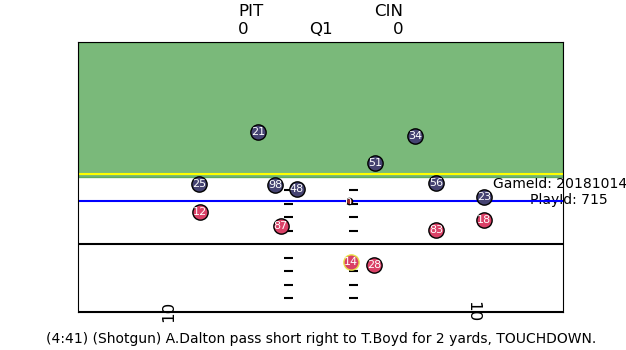

In [8]:
%matplotlib notebook

# 2018102806, 279 -- Cover 1
# 2018092301, 4074 -- WTF (Tony Jefferson #23 SS only has 7 frames)

row = random.randrange(0, len(alldf))
game = alldf['gameId'].iloc[row]
play = alldf['playId'].iloc[row]

# Arrays to store data for each player, line, and annotation 
playerData = []
linesList = []
annotateList = []

fig, ax = create_field(game, play)

def init():
    return line, annotation

# Each frame plots a player's location in that moment  
def animate_frame(i):
    x_data = {}
    y_data = {}
    
    for lnum, line in enumerate(linesList):
        x = playerData[lnum][1]['x'][i]
        y = playerData[lnum][1]['y'][i]
        x_data.update({lnum: x})
        y_data.update({lnum: y})
        line.set_data(x_data[lnum], y_data[lnum])
        annotateList[lnum].set_position((x,y))
        

animate = FuncAnimation(fig, animate_frame,
                               frames=len(playerData[0][1]['x']), interval=100, blit=False)

In [307]:
#alldf.loc[(alldf.gameId == game) & (alldf.playId == play) & (alldf.jerseyNumber == 23.0) & (alldf.position == 'SS')]
alldf.loc[(alldf.gameId == game) & (alldf.playId == play) & (alldf.displayName == 'Mason Foster')]

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,playId,playDirection,route,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
11254925,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:11.000Z,80.25,28.35,0.05,0.21,0.01,92.43,170.66,None,2495281.0,Mason Foster,54.0,ILB,1,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11254941,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:11.099Z,80.25,28.35,0.02,0.18,0.00,91.68,176.41,None,2495281.0,Mason Foster,54.0,ILB,2,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11254957,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:11.200Z,80.25,28.35,0.02,0.17,0.00,90.65,254.69,None,2495281.0,Mason Foster,54.0,ILB,3,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11254973,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:11.299Z,80.24,28.35,0.04,0.19,0.00,90.04,289.77,None,2495281.0,Mason Foster,54.0,ILB,4,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11254989,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:11.400Z,80.24,28.35,0.06,0.17,0.01,90.04,294.40,None,2495281.0,Mason Foster,54.0,ILB,5,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11256989,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:23.900Z,64.25,5.79,1.00,1.87,0.13,248.69,171.40,None,2495281.0,Mason Foster,54.0,ILB,130,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11257005,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:24.000Z,64.28,5.67,1.15,1.80,0.12,206.44,162.24,None,2495281.0,Mason Foster,54.0,ILB,131,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11257021,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:24.099Z,64.30,5.55,1.27,1.44,0.12,164.85,160.49,None,2495281.0,Mason Foster,54.0,ILB,132,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,10.0,7.0,13:07:00,86.0,NaN,NaN,IN,0,0,-2.51973,False
11257037,2018111806,11/18/2018,13:00:00,WAS,HOU,11,2018-11-18T18:50:24.200Z,64.34,5.43,1.36,1.04,0.13,139.48,159.89,tackle,2495281.0,Mason Foster,54.0,ILB,133,home,1188,left,NaN,(13:07) (Shotgun) D.Watson pass deep left inte...,2,3,11,HOU,play_type_pass,HOU,24,SHOTGU